In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data_orig = pd.read_csv('../MA_PREDICTOR/data/ma_detailed_data_car.csv', parse_dates=['announcement_date'])

In [4]:
data_orig.columns

Index(['id', 'announcement_date', 'deal_value', 'acquiror_total_assets',
       'acquiror_name', 'acquiror_ticker', 'target_name', 'target_nation',
       'acquiror_nation', 'target_status', 'acquiror_industry',
       'target_industry', 'shares_at_announcement', 'shares_acquired',
       'consideration_offered', 'attitude', 'acquisition_technique',
       'acquiror_financial_advisor', 'target_financial_advisor', 'purpose',
       'acquiror_code', 'target_code', 'car'],
      dtype='object')

In [5]:
# Defining which columns should be considered in detailed investigations
columns_to_inspect = [
    'deal_value',
    'acquiror_total_assets',
    'acquiror_name',
    'target_name',
    'acquiror_industry',
    'target_industry',
    'shares_acquired',
    'acquisition_technique',
    'purpose',
    'car'
]

# Outliers

## Detecting outliers

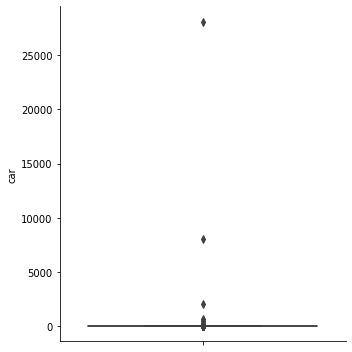

In [6]:
sns.catplot(data=data_orig, y='car', kind='box')

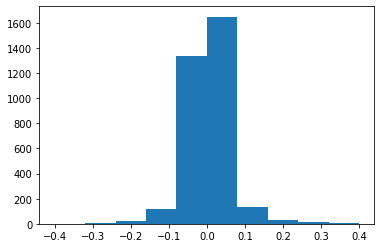

In [7]:
plt.hist(data_orig.car, range=(-0.4, 0.4));

## Excluding outliers

In [8]:
# Defining outlier threshold
car_thresh = 1

# Filtering outliers
data = data_orig[(abs(data_orig.car) < car_thresh)]

In [9]:
(len(data_orig) - len(data)) / len(data_orig)

0.003003003003003003

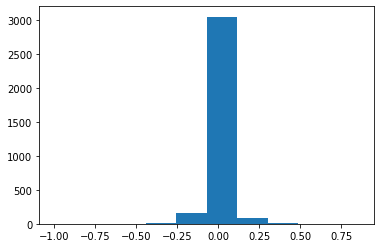

In [11]:
plt.hist(data.car);

# deal_value

## Absolute

In [149]:
data.deal_value.describe()

count     3320.000000
mean      1300.103810
std       4557.812864
min          0.070000
25%         61.590000
50%        258.165000
75%        800.000000
max      79406.460000
Name: deal_value, dtype: float64

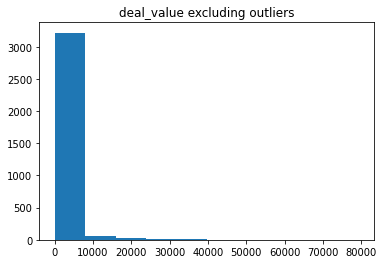

In [150]:
plt.hist(data.deal_value,
         # range=(0,1000)
        )
plt.title('deal_value excluding outliers');

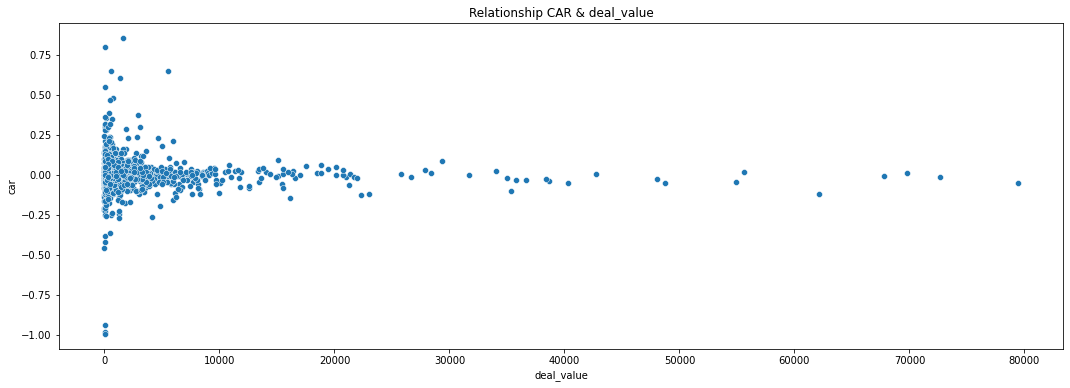

In [151]:
plt.figure(figsize=(18,6))
plt.title("Relationship CAR & deal_value")
sns.scatterplot(data=data, x='deal_value', y='car');

## Relative (tbc with percentage of shares acquired)

In [152]:
data.acquiror_total_assets.value_counts()[0]

1

In [153]:
# Dividing deal value by total assets to retrieve relative (to the size of acquiror) deal value
relative = data.copy()
relative['rel_deal_value'] = data.apply(lambda row:
                                       row.deal_value / row.acquiror_total_assets
                                       if row.acquiror_total_assets # one observation has 0 total assets and
                                       else -1000, # will be filtered out
                                       axis=1)

# Filtering out acquiror_total_assets = 0
relative = relative[relative.rel_deal_value > 0]

In [154]:
relative.rel_deal_value.describe()

count     3319.000000
mean         7.667271
std        286.003307
min          0.000004
25%          0.019882
50%          0.062728
75%          0.205659
max      14804.666667
Name: rel_deal_value, dtype: float64

In [155]:
len(relative[relative.rel_deal_value > 1]) # to see that 184 deals have fishy relative deal size

184

In [156]:
relative[relative.rel_deal_value > 1][columns_to_inspect].sample(5)

,deal_value,acquiror_total_assets,acquiror_name,target_name,acquiror_industry,target_industry,shares_acquired,acquisition_technique,purpose,car
2865,377.95,137.34,iAnthus Capital Holdings Inc,MPX Bioceutical Corp,Pharmaceuticals,Pharmaceuticals,100.0,Reverse Takeover|Stock Swap|Schemeof Arrangement,Strengthen operations,0.000000
3133,444.14,0.03,Oncbiomune Pharmaceuticals Inc,Avant Diagnostics Inc-Assets,Pharmaceuticals,Healthcare Facilities & Services,100.0,Divestiture|Reverse Takeover,Strengthen operations,0.464903
2794,605.99,442.71,Akebia Therapeutics Inc,Keryx Biopharmaceuticals Inc,Pharmaceuticals,Biotechnology & Medical Research,100.0,Reverse Takeover|Stock Swap|Mergerof Equals|Fi...,Allow to offer new products and services|Expan...,-0.068357
3245,600.00,457.16,Veracyte Inc,Decipher Biosciences Inc,Healthcare Facilities & Services,Healthcare Facilities & Services,100.0,Financial Acquiror,"Strengthen operations|Create synergies, elimin...",-0.040150
3108,1294.88,931.39,Cornerstone OnDemand Inc,Saba Software Inc,Software,Software,100.0,Divestiture,Strengthen operations,-0.269413


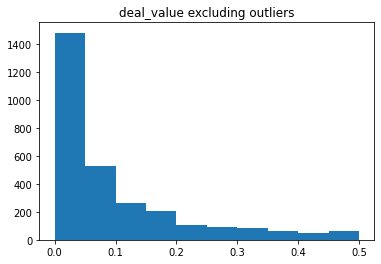

In [157]:
plt.hist(relative.rel_deal_value,
         range=(0,0.5)
        )
plt.title('deal_value excluding outliers');

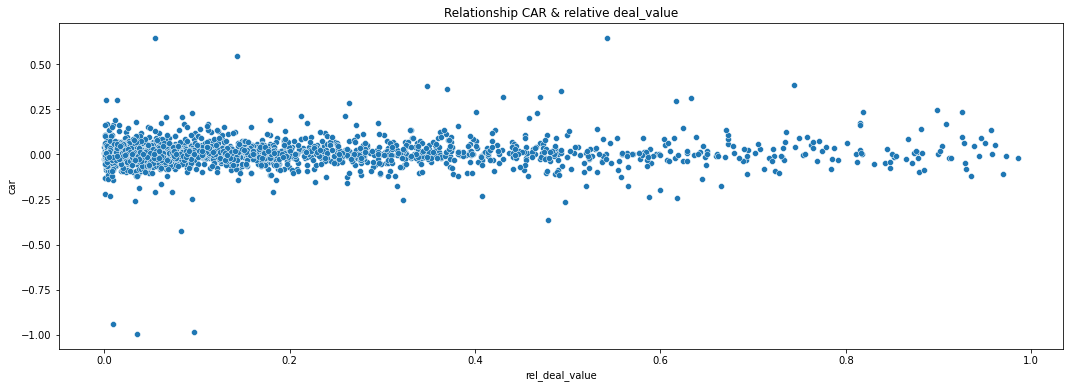

In [158]:
# Defining outlier threshold
thresh = 1

# Scatterplot
plt.figure(figsize=(18,6))
plt.title("Relationship CAR & relative deal_value")
sns.scatterplot(data=relative[relative.rel_deal_value < thresh], x='rel_deal_value', y='car');

# Target exploration

In [485]:
car_explo = data.copy()
classifier = lambda x: 'positive' if x > 0 else 'negative'
car_explo['classifier'] = car_explo.car.apply(classifier)

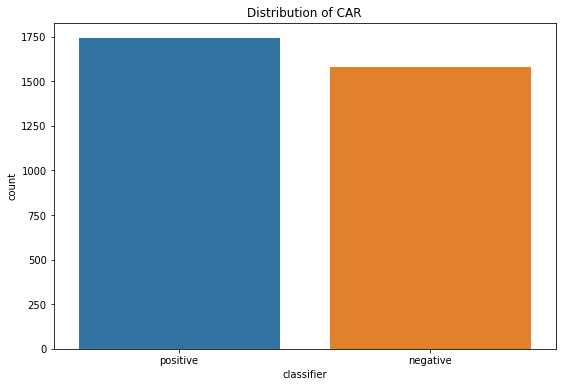

In [486]:
plt.figure(figsize=(9,6))
plt.title("Distribution of CAR")
sns.countplot(x=car_explo.classifier);

# ..._nation

In [159]:
# Creating dataframe with cross-border feature

nation = data[['acquiror_nation', 'target_nation', 'car']].copy()
nation['cross_border'] = nation.apply(lambda row: 'cross_border' if row.acquiror_nation == row.target_nation else 'national', axis=1)

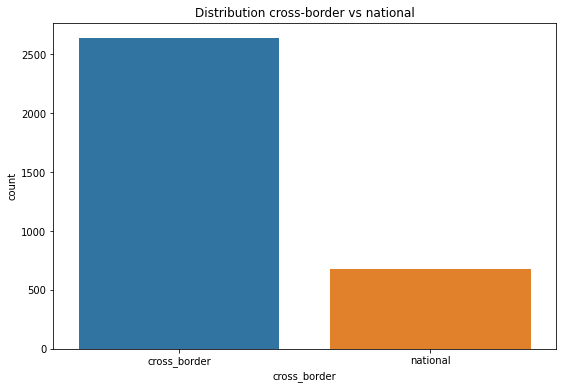

In [160]:
# Distribution

plt.figure(figsize=(9,6))
plt.title("Distribution cross-border vs national")
sns.countplot(x=nation.cross_border);

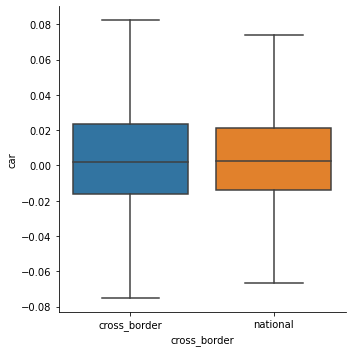

In [161]:
# Impact on target
sns.catplot(data=nation, x='cross_border', y='car', kind='box',
            showfliers=False
           );

# shares_...

In [40]:
# Clustering into full acquisition and not full-acquisition

shares = data[['car']].copy()

# Divide into full (100%) and not full
def full_acqu(x):
    if x != 100:
        return 'not_full'
    return 'full'

shares['acquisition'] = data.apply(lambda row: full_acqu(row.shares_acquired), axis=1)

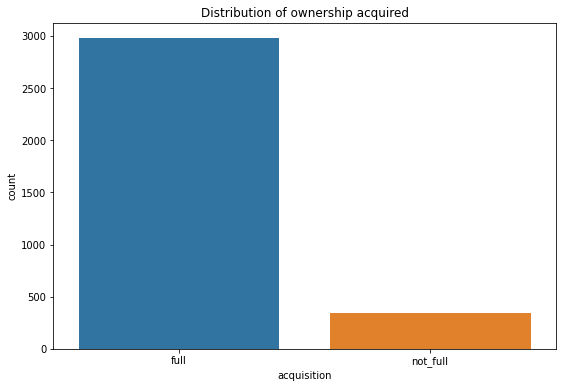

In [41]:
# Distribution

plt.figure(figsize=(9,6))
plt.title("Distribution of ownership acquired")
sns.countplot(x=shares.acquisition);

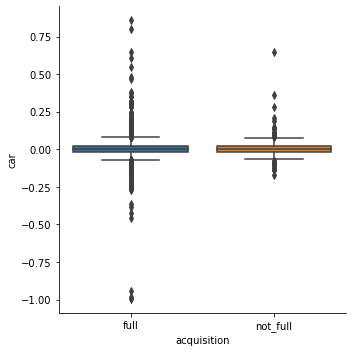

In [43]:
# Impact on target

sns.catplot(data=shares, x='acquisition', y='car', kind='box',
            #showfliers=False
           );

# consideration_offered

In [44]:
# Preprocess

consideration = data[['consideration_offered', 'car']].copy()
# has to be transformed first -> everything that only has cash will be 'cash', rest 'other'

# transform pipes into list of all considerations
list_gen = lambda x: x.split('|')
consideration['consideration_offered'] = consideration.consideration_offered.apply(list_gen)

# Cluster considerations
def cash(considerations):
    
    for consideration in considerations:
        if 'Cash' not in consideration:
            return 'Other'
    return 'Cash'

# Apply
consideration['consideration_offered'] = consideration.apply(lambda row: cash(row.consideration_offered), axis=1)

In [163]:
data.car.describe()

count    3320.000000
mean        0.005172
std         0.069531
min        -0.996250
25%        -0.015647
50%         0.001996
75%         0.022851
max         0.857922
Name: car, dtype: float64

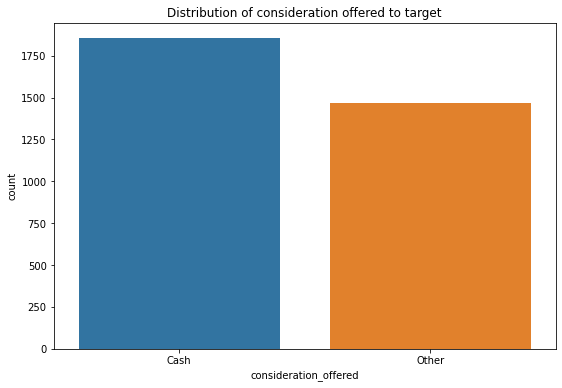

In [45]:
# Distribution
plt.figure(figsize=(9,6))
plt.title("Distribution of consideration offered to target")
sns.countplot(x=consideration.consideration_offered);

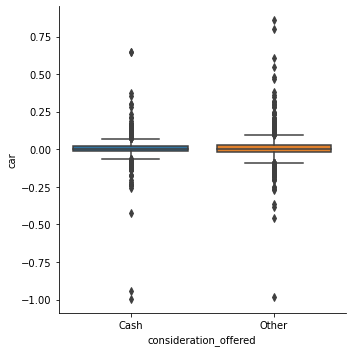

In [47]:
# Impact on target
sns.catplot(data=consideration, x='consideration_offered', y='car', kind='box',
            #showfliers=False
           );

# acquisition_techniques (tbc after Vlad's research)

In [51]:
technique = data[['car']]

In [125]:
# unpack techniques and put them into set
techniques = set()
for index, row in data.iterrows():
    for technique in row.acquisition_technique.split('|'):
        if technique:
            techniques.add(technique)

In [128]:
techniques

{'Acquiror Includes Management',
 'Acquiror Is A White Knight',
 'Acquiror Is An Investor Group',
 'Asset Swap',
 'Auction',
 'Bankruptcy Acquisition',
 'Collar',
 'Concession',
 'Debt Restructuring',
 'Divestiture',
 'Financial Acquiror',
 'Going Private',
 'Institutional Buyout',
 'Internal Reorganization',
 'Joint Venture',
 'Leveraged Buyout',
 'Litigation',
 'Mandatory Offering',
 'Mergerof Equals',
 'Open Market Purchase',
 'Private Tender Offer',
 'Privately Negotiated Purchase',
 'Privatization',
 'Property Acquisition Flag',
 'Proxy Fight',
 'Restructuring',
 'Reverse Morris Trust',
 'Reverse Takeover',
 'Rumored Deal',
 'Sale and Leaseback',
 'Schemeof Arrangement',
 'Secondary Buyout',
 'Stock Swap',
 'Tender Merger',
 'Tender Offer',
 'Three Way Merger',
 'Unsolicited Deal'}

In [125]:
# Define columns that should be excluded (based on research and investigation of deals)

to_exclude = [
    'Open Market Purchase', # 3 deals only
    'Privately Negotiated Purchase', # should only be excluded if target and acquiror name are same
    'Debt Restructuring' # 3 deals, not a merger (shares acquired <10)
]

## Investigation: Fishy techniques

In [207]:
# Further investigation into 'Divestiture' and 'Stock Swap'
investigation = data.copy()

# Transforming pipes into lists of techniques used
list_gen = lambda x: x.split('|')
investigation['acquisition_technique'] = investigation.acquisition_technique.apply(list_gen)

# Cluster considerations
def fishy(techniques):
    
    # Define fishy techniques
    fishy_techniques = [
        'Divestiture'
    ]
    
    # Label fishy techniques
    for technique in techniques:
        if technique in fishy_techniques:
            return 'fishy'
    return 'ok'

# Apply detector
investigation['red_flag'] = investigation.apply(lambda row: fishy(row.acquisition_technique), axis=1)

In [208]:
# Counting number of occurences
investigation.red_flag.value_counts()

fishy    1884
ok       1436
Name: red_flag, dtype: int64

In [279]:
# Filtering out fishy deals
investigation[investigation.red_flag == 'fishy'][columns_to_inspect].sample(1)

,deal_value,acquiror_total_assets,acquiror_name,target_name,acquiror_industry,target_industry,shares_acquired,acquisition_technique,purpose,car
2663,8064.92,19238.0,MPLX LP,Marathon Petroleum Corp-Refining Logistics Ass...,Oil & Gas Transportation Services,Oil & Gas Refining and Marketing,100.0,[Divestiture],Allow to offer new products and services|Stren...,-0.032773


# acquiror_financial_advisor (& target_financial_advisor)

**3 options of impact**:
* acquiror financial advisor (makes most sense, since CAR is measured on acquirors side)
* target financial advisor
* advisors involved in deal

In [264]:
# Missing data in percent, might not need to exclude but used as category e.g., 'unknown' -> no top acquiror
data[['acquiror_financial_advisor', 'target_financial_advisor']].isna().sum() / len(data)

acquiror_financial_advisor    0.475301
target_financial_advisor      0.361446
dtype: float64

In [265]:
adv = data[['acquiror_financial_advisor', 'target_financial_advisor', 'car']].copy()

# Filling up NAs with 'Unknown'
adv.fillna('Unknown', inplace=True)

# unpack advisors and put them into set
advisors = set()
for index, row in adv.iterrows():
    for advisor in row['acquiror_financial_advisor'].split('|'):
        advisors.add(advisor)
    for advisor in row['acquiror_financial_advisor'].split('|'):
        advisors.add(advisor)

**Top 10 M&A advisors sourced from dealroom (https://dealroom.net/blog/biggest-m-a-firms)**

In [266]:
# Deefining list of top M&A advisors
base = ['Barclays', 'Bank of America', 'Citi', 'Credit Suisse','Goldman Sachs',
        'JP Morgan', 'Lazard', 'Morgan Stanley', 'Rothschild', 'UBS']

# Adjust advisor's name to dataset (preliminary operation)
top_advisors = []
for advisor in advisors: # iterating through set of advisors
    for top_advisor in base:
        if top_advisor in advisor: # if (base) name of top_advisors is in set append
            top_advisors.append(advisor)
            
top_advisors = sorted(top_advisors)

# Manually investigate top_advisors and append/ remove accordingly
top_advisors.remove('Mitsubishi UFJ Morgan Stanley')

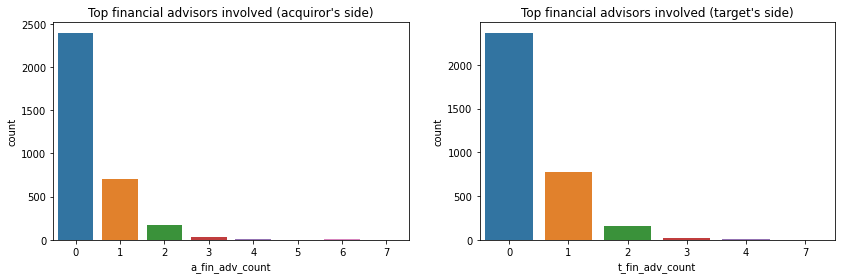

In [332]:
# Find out how many top_advisors were involved in transaction

adv = data[['acquiror_financial_advisor', 'target_financial_advisor', 'car']].copy()

# Filling up NAs with 'Unknown'
adv.fillna('Unknown', inplace=True)

# Features to transform
parties = ['acquiror_financial_advisor', 'target_financial_advisor']

# Transforming advisor pipe(s) into lists to iterate through
list_gen = lambda x: x.split('|')

for party in parties:
    adv[party] = adv[party].apply(list_gen)

# Counting number of top_advisors per deal (acquiror_side)
def counter(advisors):
    count = 0
    for advisor in advisors:
        if advisor in top_advisors:
            count += 1
    return count

# Create new cols for acquiror and target
adv['a_fin_adv_count'] = adv.apply(lambda row: counter(row.acquiror_financial_advisor), axis=1)
adv['t_fin_adv_count'] = adv.apply(lambda row: counter(row.target_financial_advisor), axis=1)

plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
plt.title("Top financial advisors involved (acquiror's side)")
sns.countplot(x=adv.a_fin_adv_count);

plt.subplot(1, 2, 2)
plt.title("Top financial advisors involved (target's side)")
sns.countplot(x=adv.t_fin_adv_count);

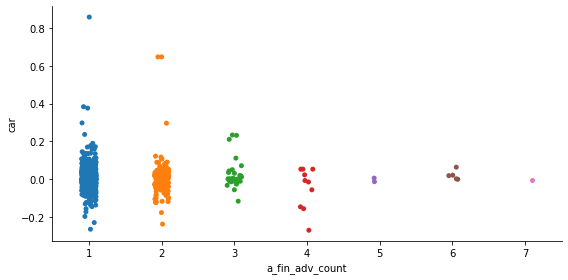

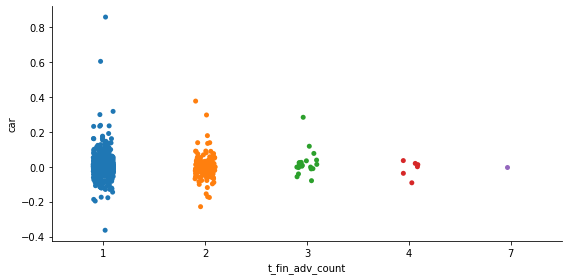

In [333]:
# Exclude 0 -> yes: excl=1, no: excl=0
excl = 1

# acquiror
sns.catplot(data=adv[adv.a_fin_adv_count >= excl], x='a_fin_adv_count', y='car',
            #kind='box',
            height=4, aspect=2);
# target
sns.catplot(data=adv[adv.t_fin_adv_count >= excl], x='t_fin_adv_count', y='car',
            #kind='box',
            height=4, aspect=2);

# purpose

In [461]:
# Number of different purpose combinations in dataset
print('# of different purpose combinations:', data.purpose.nunique())
print('Other given as purpose:', len(data[data.purpose == 'Other']))

# of different purpose combinations: 744
Other given as purpose: 0


In [429]:
# Examples of combinations
i = np.random.randint(0, (data.purpose.nunique()-10))
for comb in data.purpose.unique()[i:i+5]:
    print('---')
    print(comb)

---
Strengthen existing operations/expand presence in primary market|Expand presence in new geographical regions|Concentrate on core businesses/assets
---
Strengthen operations|Create synergies, eliminate duplicate services/operations|Increase shareholder value|Allow to offer new products and services
---
Other|Strengthen existing operations/expand presence in primary market
---
Create synergies, eliminate duplicate services/operations|General strategy to take advantage of sound investment opportunities|Expand presence in new geographical regions|Increase shareholder value/dilute number of outstanding shares
---
Other|Create synergies, eliminate duplicate services/operations|Allow to offer new products and services|Increase shareholder value|Expand presence in new geographical regions|Strengthen operations


In [399]:
# Finding unique purposes

# Unpack purposes and put them into set to find uniques
purposes_all = set()
for index, row in data.iterrows():
    for purpose in row.purpose.split('|'):
        purposes_all.add(purpose)

In [400]:
# Creating dataframe
purp = data[['purpose', 'car']].copy()

# Transform pipes into lists
list_gen = lambda x: x.split('|')
purp.purpose = purp.purpose.apply(list_gen)

# Create 24 empty coloumns (0s) for every purpose
for purpose in purposes_all:
    purp[purpose] = 0
    
# Fill coloumns for every deal
def purpose_finder(index, purposes):
    for purpose in purposes:
        purp.loc[index, purpose] = 1
        
purp.apply(lambda row: purpose_finder(row.name, row.purpose), axis=1);

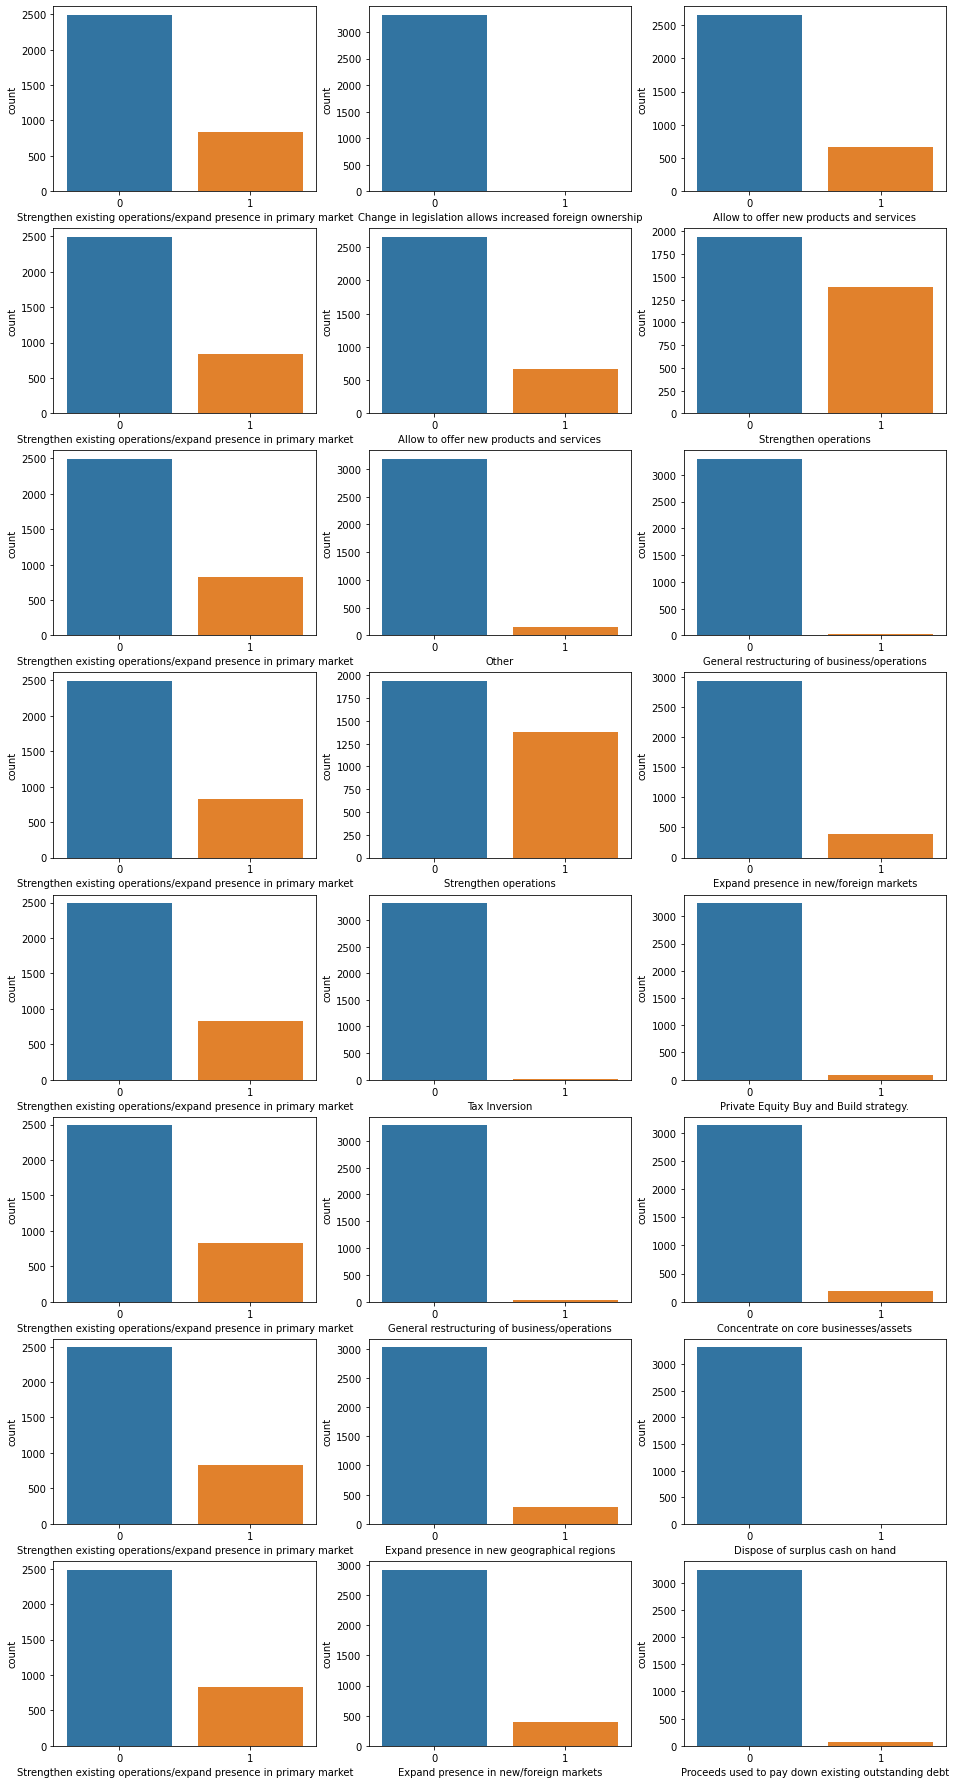

In [459]:
fig, axes = plt.subplots(8,3, figsize=(16, 32))

for x in range(8):
    for y in range(3):
        purpose = list(purposes_all)[x*y + y]
        sns.countplot(x=purp[purpose], ax=axes[x][y])

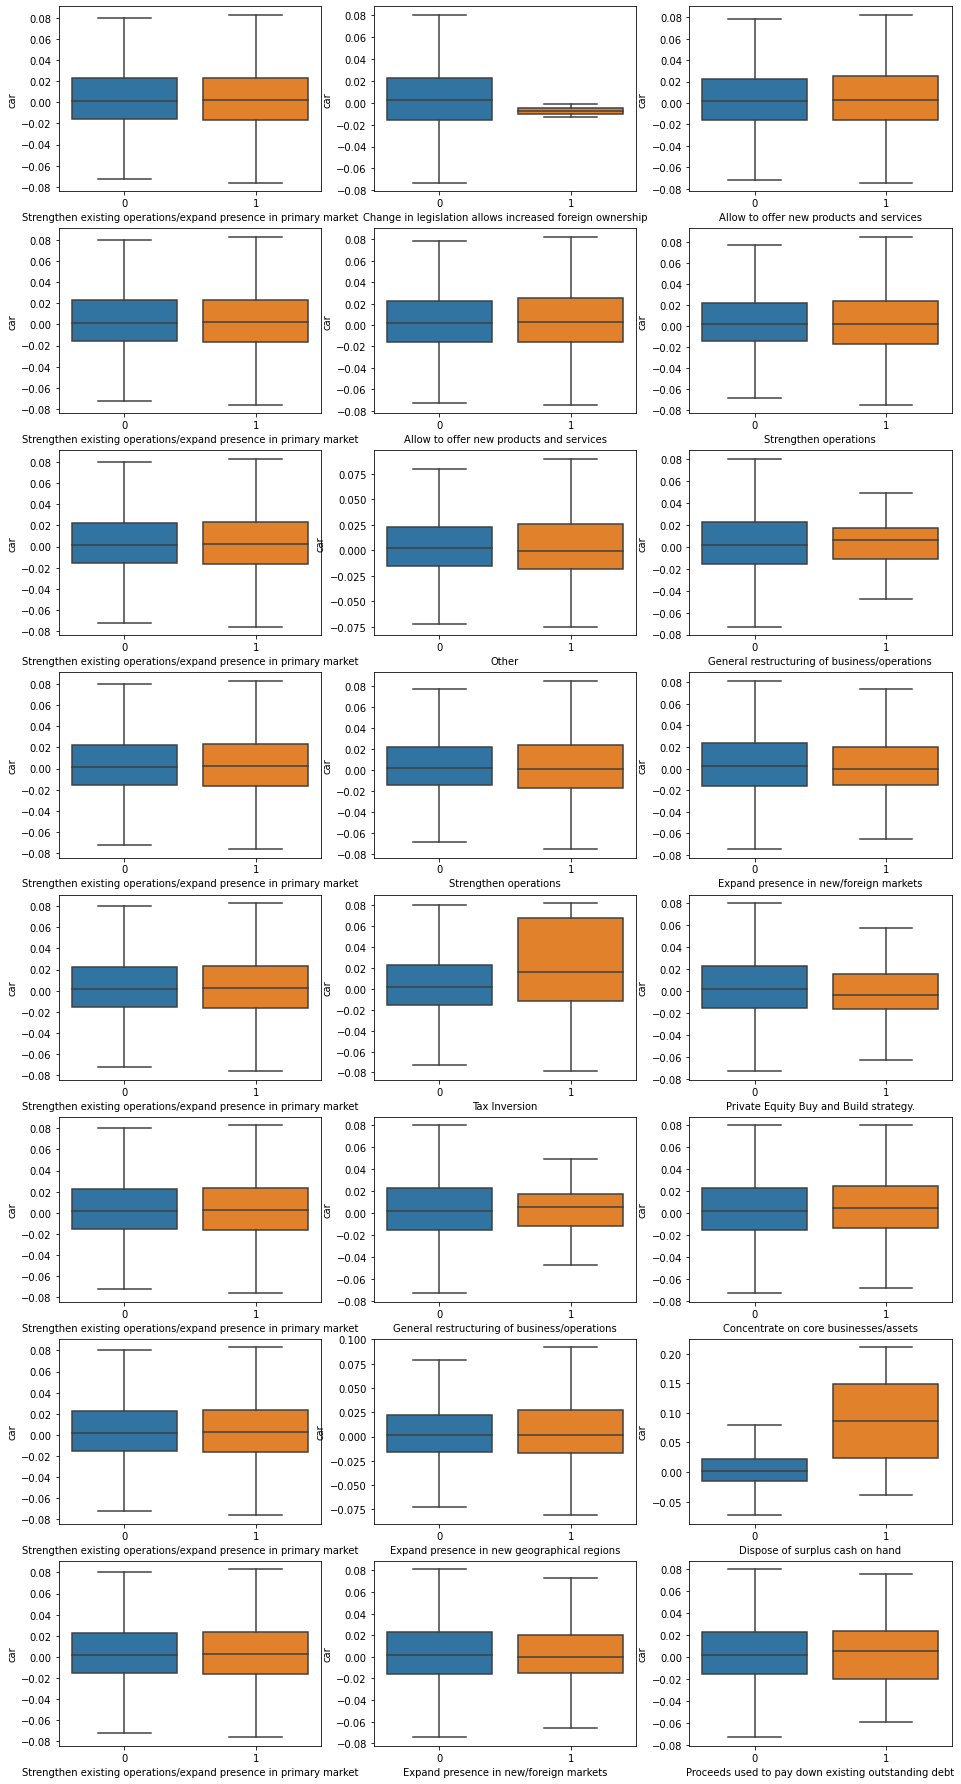

In [474]:
fig, axes = plt.subplots(8,3, figsize=(16, 32))

for x in range(8):
    for y in range(3):
        purpose = list(purposes_all)[x*y + y]
        sns.boxplot(data=purp, x=purpose, y='car',
                    showfliers=False,
                    ax=axes[x][y]
                   );

# industry_relatedness (acquiror_code, target_code)

**Relatedness from top to bottom:**
1. Same industry (Iron & Steel)
2. Same industry group (Metals & Mining)
3. Same business sector (Mineral Resources)
4. Same economic sector (Basic Materials)
5. Not related

In [404]:
rel = data[['car']].copy()

In [405]:
# Transform codes

def relatedness(acquiror, target):
    if acquiror == target:
        return 'industry'
    elif acquiror[:6] == target[:6]:
        return 'industry_group'
    elif acquiror[:4] == target[:4]:
        return 'business_sector'
    elif acquiror[:2] == target[:2]:
        return 'economic_sector'
    else:
        return 'not_related'

In [406]:
rel['relatedness'] = data.apply(lambda row: relatedness(str(row.acquiror_code), str(row.target_code)), axis=1)

## Distribution

In [407]:
rel.relatedness.value_counts()

industry           1507
not_related         938
industry_group      340
business_sector     317
economic_sector     218
Name: relatedness, dtype: int64

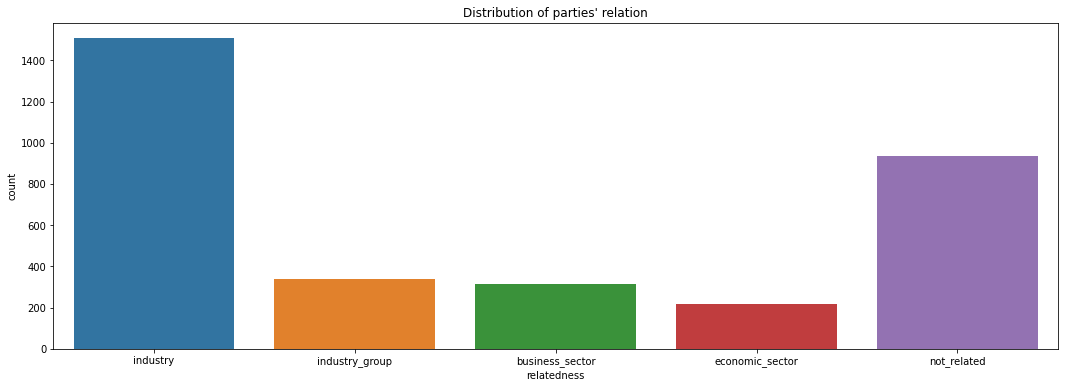

In [408]:
order = ['industry', 'industry_group', 'business_sector', 'economic_sector', 'not_related']

plt.figure(figsize=(18,6))
plt.title("Distribution of parties' relation")
sns.countplot(x=rel.relatedness, order=order);

## Impact on target

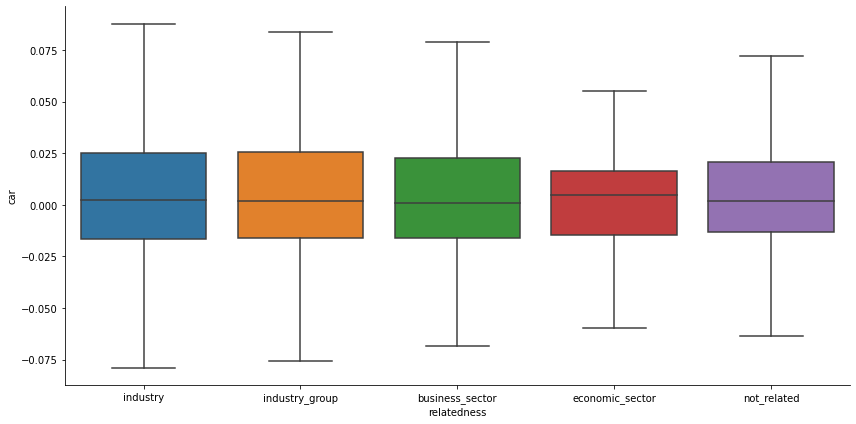

In [409]:
sns.catplot(data=rel, x='relatedness', y='car', kind='box', order=order, showfliers=False, height=6, aspect=2);

# acquiror_industry

## Preprocessing

In [35]:
# we can access information on industry on acquiror_id (8 digit code, 2 per level of classification)
print('example acquiror_code:', data.acquiror_code[0])

example acquiror_code: 50102030


* 0-2 gives economic_sector
* 0-4 gives business_sector
* 0-6 gives industry_group
* 0-8 gives industry

In [220]:
# transform code into different cols mentioned above
def declassifier(x):
    x = str(x)
    return x[:2], x[:4], x[:6], x

In [221]:
tmp = data[['car']].copy()
tmp['economic_sector'], tmp['business_sector'], tmp['industry_group'], tmp['industry'] = \
zip(*data['acquiror_code'].map(declassifier))

In [298]:
tmp

,car,economic_sector,business_sector,industry_group,industry
0,0.006854,50,5010,501020,50102030
1,-0.010266,54,5420,542010,54201030
2,0.007746,57,5720,572010,57201030
3,-0.011133,52,5210,521020,52102010
4,-0.003971,50,5010,501020,50102030
...,...,...,...,...,...
18454,0.020108,52,5210,521020,52102010
18455,-0.040156,53,5320,532030,53203020
18456,-0.003545,54,5430,543010,54301020
18457,-0.025992,55,5510,551010,55101010


## economic_sector

### Distribution

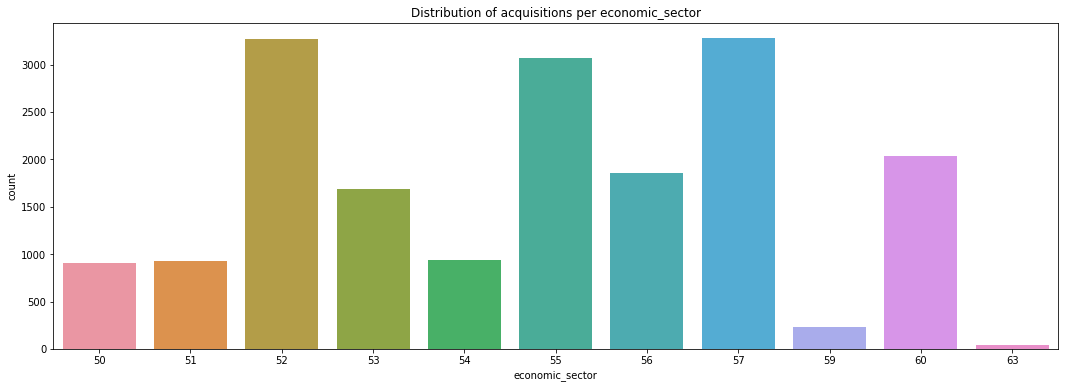

In [299]:
order = sorted(tmp.economic_sector.unique())

plt.figure(figsize=(18,6))
plt.title("Distribution of acquisitions per economic_sector")
sns.countplot(x=tmp.economic_sector, order=order);

### Impact on target

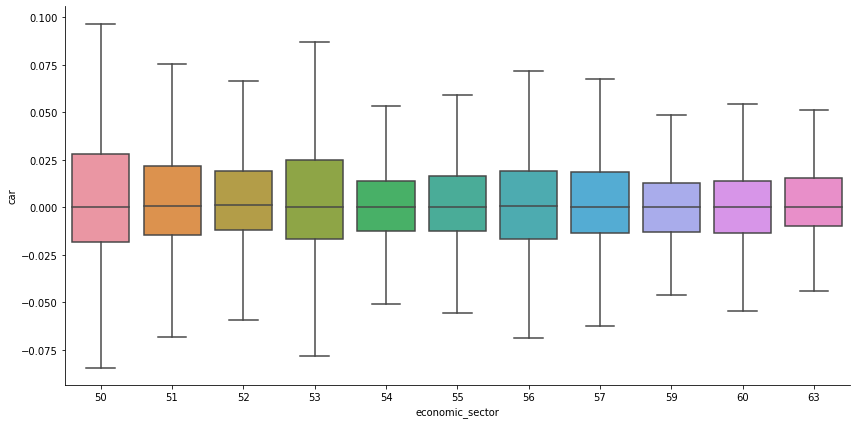

In [300]:
sns.catplot(data=tmp, x='economic_sector', y='car', kind='box', order=order, showfliers=False, height=6, aspect=2);

## business_sector

In [301]:
print(tmp.business_sector.nunique()) # 29 sectors
tmp.business_sector.nunique() # 29 sectors

29


29

### Distribution

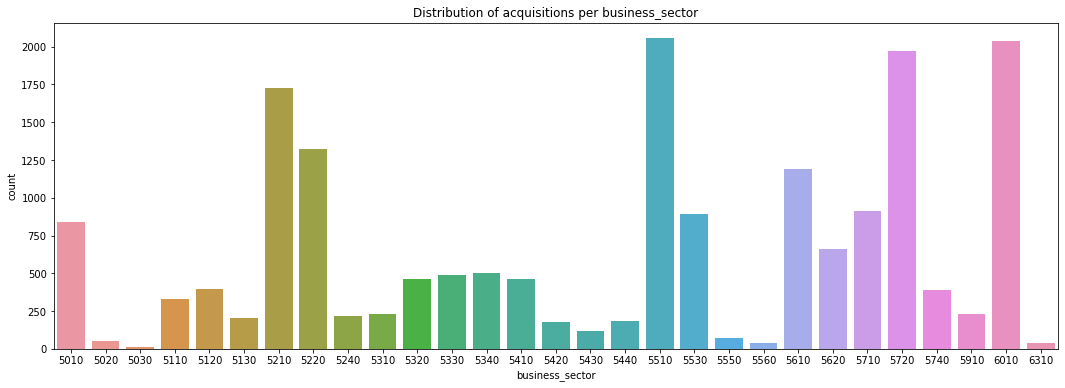

In [302]:
sectors = sorted(tmp.business_sector.unique())

plt.figure(figsize=(18,6))
plt.title("Distribution of acquisitions per business_sector")
sns.countplot(x=tmp.business_sector, order=sectors);

### Impact on target

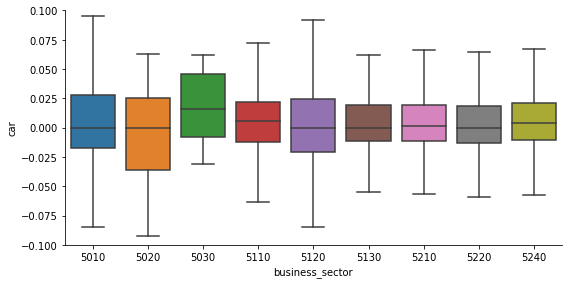

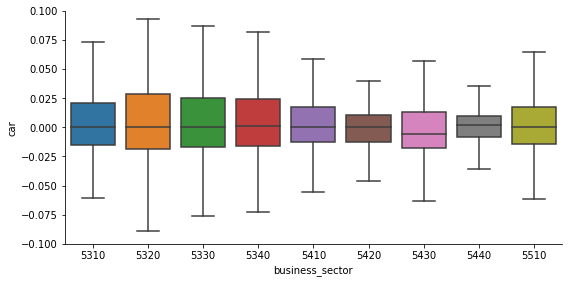

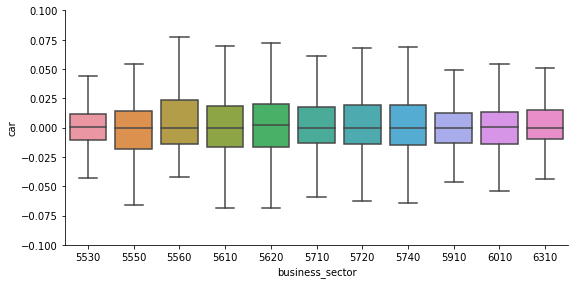

In [303]:
i = int(tmp.business_sector.nunique() / 3)
p1 = sectors[:i]
p2 = sectors[i: i + i]
p3 = sectors[i + i:]
tmp1 = tmp.loc[tmp['business_sector'].isin(p1)]
tmp2 = tmp.loc[tmp['business_sector'].isin(p2)]
tmp3 = tmp.loc[tmp['business_sector'].isin(p3)]
df = [tmp1, tmp2, tmp3]
order = [p1, p2, p3]

for df, order in zip(df, order):
    sns.catplot(data=df, x='business_sector', y='car',
                kind='box', order=order, showfliers=False, height=4, aspect=2).set(ylim=(-0.1, 0.1));

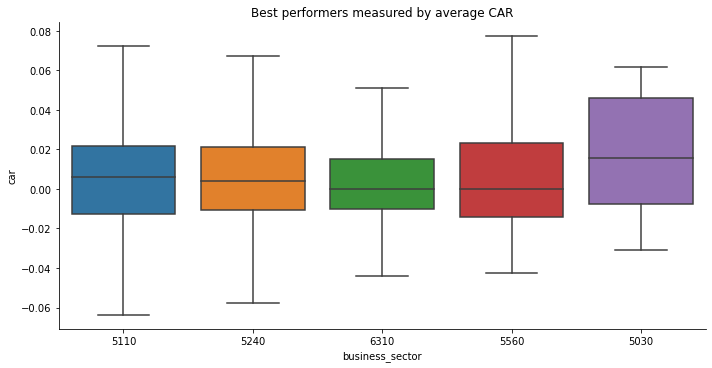

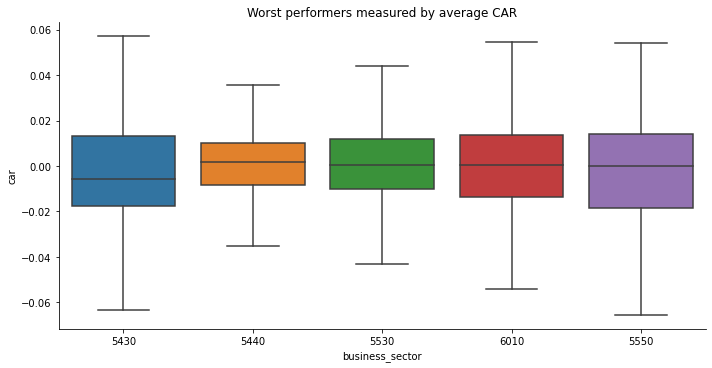

In [304]:
# filtering out best performing industries
top = tmp.groupby(by='business_sector').mean().sort_values(by='car', ascending=False).head(5).index
top_df = tmp.loc[tmp['business_sector'].isin(top)]
sns.catplot(data=top_df, x='business_sector', y='car',
            kind='box', showfliers=False, height=5, aspect=2
           ).set(title='Best performers measured by average CAR');
# print('top:', top_df.business_sector.value_counts()) # to count their occurence

# print('-------')

# filtering out worst performing industries
flop = tmp.groupby(by='business_sector').mean().sort_values(by='car', ascending=False).tail(5).index
flop_df = tmp.loc[tmp['business_sector'].isin(flop)]
sns.catplot(data=flop_df, x='business_sector', y='car',
            kind='box', showfliers=False, height=5, aspect=2
           ).set(title='Worst performers measured by average CAR')
# print('flop:', flop_df.business_sector.value_counts()) # to count their occurence

## industry_group

In [191]:
tmp.industry_group.nunique() # 55 sectors

55

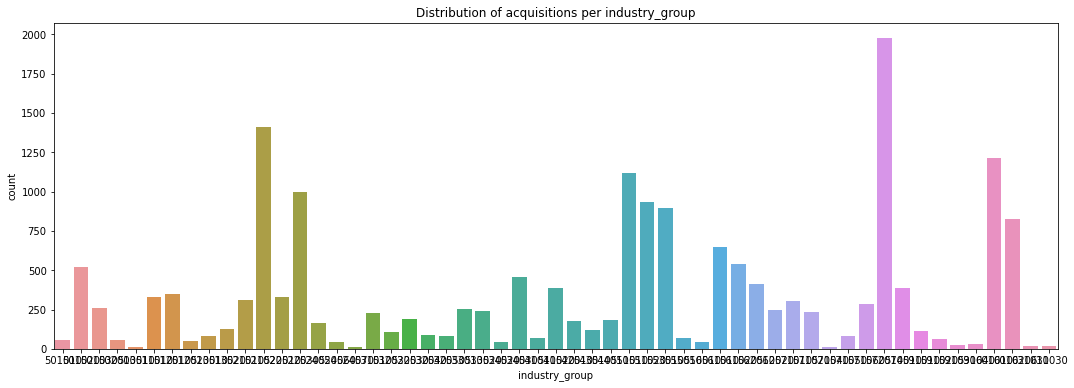

In [192]:
order = sorted(tmp.industry_group.unique())

plt.figure(figsize=(18,6))
plt.title("Distribution of acquisitions per industry_group")
sns.countplot(x=tmp.industry_group, order=order);

# target_industry

In [208]:
tmp['economic_sector'], tmp['business_sector'], tmp['industry_group'], tmp['industry'] = \
zip(*data['target_code'].map(declassifier))

/var/folders/z8/077xt3wd30j28k4_3vtz7gn00000gn/T/ipykernel_77799/2819975884.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['economic_sector'], tmp['business_sector'], tmp['industry_group'], tmp['industry'] = \


## economic_sector

### Distribution

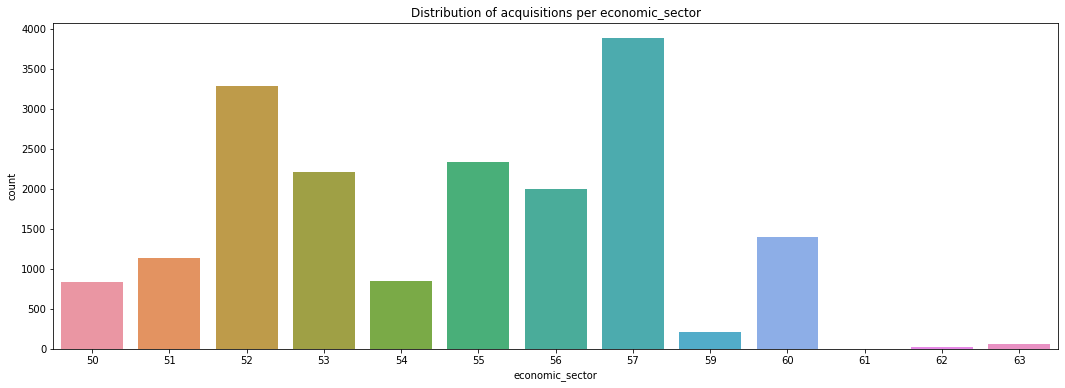

In [212]:
order = sorted(tmp.economic_sector.unique())

plt.figure(figsize=(18,6))
plt.title("Distribution of acquisitions per economic_sector")
sns.countplot(x=tmp.economic_sector, order=order);

### Impact on target

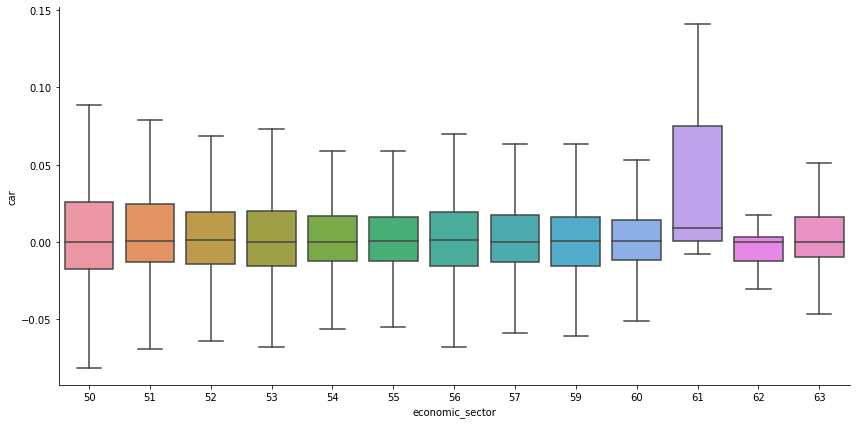

In [214]:
sns.catplot(data=tmp, x='economic_sector', y='car', kind='box', order=order, showfliers=False, height=6, aspect=2);

## business_sector

In [ ]:
print(tmp.business_sector.nunique()) # 29 sectors
tmp.business_sector.nunique() # 29 sectors

### Distribution

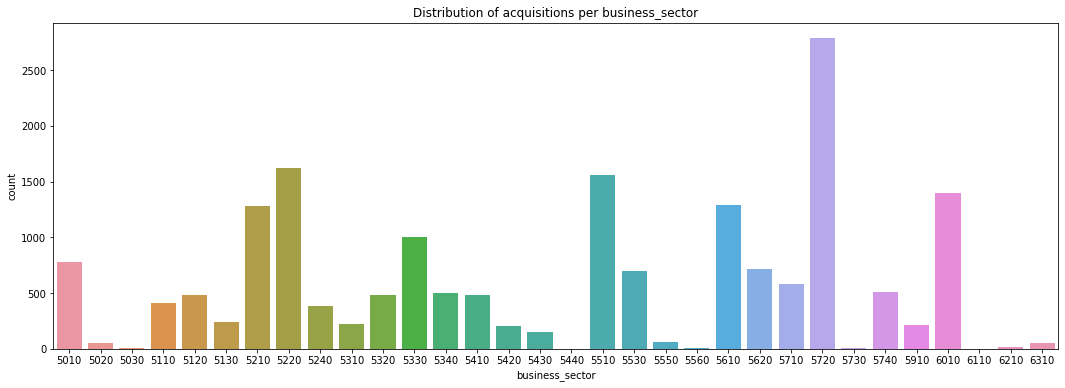

In [217]:
sectors = sorted(tmp.business_sector.unique())

plt.figure(figsize=(18,6))
plt.title("Distribution of acquisitions per business_sector")
sns.countplot(x=tmp.business_sector, order=sectors);

### Impact on target

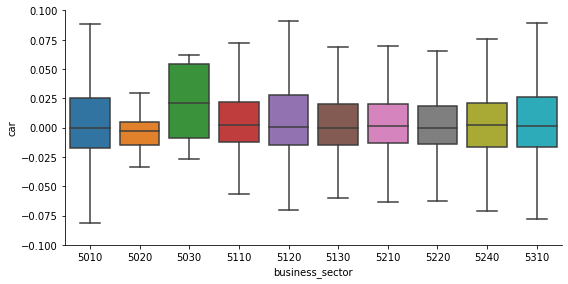

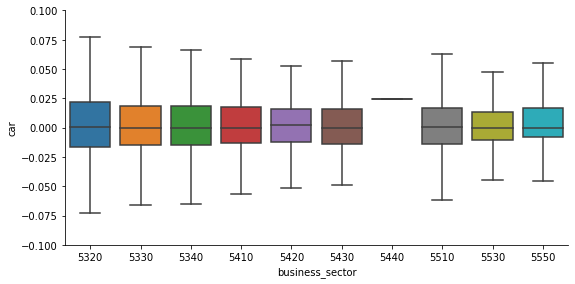

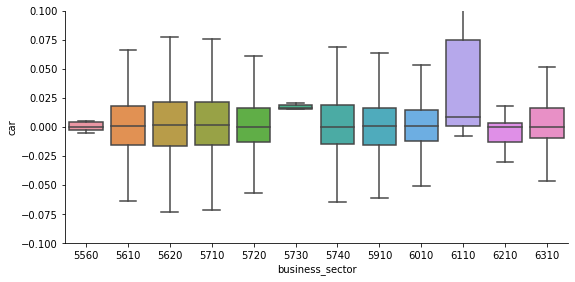

In [219]:
i = int(tmp.business_sector.nunique() / 3)
p1 = sectors[:i]
p2 = sectors[i: i + i]
p3 = sectors[i + i:]
tmp1 = tmp.loc[tmp['business_sector'].isin(p1)]
tmp2 = tmp.loc[tmp['business_sector'].isin(p2)]
tmp3 = tmp.loc[tmp['business_sector'].isin(p3)]
df = [tmp1, tmp2, tmp3]
order = [p1, p2, p3]

for df, order in zip(df, order):
    sns.catplot(data=df, x='business_sector', y='car',
                kind='box', order=order, showfliers=False, height=4, aspect=2).set(ylim=(-0.1, 0.1));

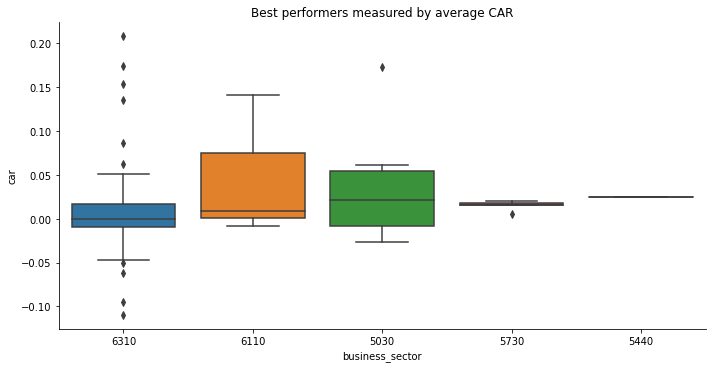

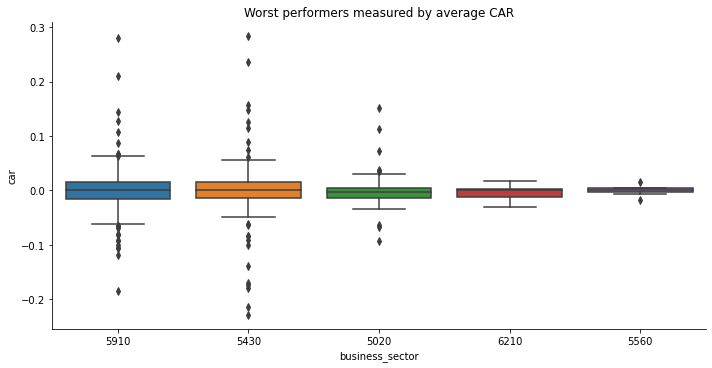

In [221]:
# filtering out best performing industries
top = tmp.groupby(by='business_sector').mean().sort_values(by='car', ascending=False).head(5).index
top_df = tmp.loc[tmp['business_sector'].isin(top)]
sns.catplot(data=top_df, x='business_sector', y='car',
            kind='box', showfliers=True, height=5, aspect=2
           ).set(title='Best performers measured by average CAR');
# print('top:', top_df.business_sector.value_counts()) # to count their occurence

# print('-------')

# filtering out worst performing industries
flop = tmp.groupby(by='business_sector').mean().sort_values(by='car', ascending=False).tail(5).index
flop_df = tmp.loc[tmp['business_sector'].isin(flop)]
sns.catplot(data=flop_df, x='business_sector', y='car',
            kind='box', showfliers=True, height=5, aspect=2
           ).set(title='Worst performers measured by average CAR');
# print('flop:', flop_df.business_sector.value_counts()) # to count their occurence